<h1 style = "font-size:3rem;color:orange">Extracting Frequency-Domain Audio Features</h1>

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa                  
import librosa.display 
import IPython.display as ipd
import scipy

In [2]:
# import audio to analyse
data, sr = librosa.load('../samples/Trumpet.wav')

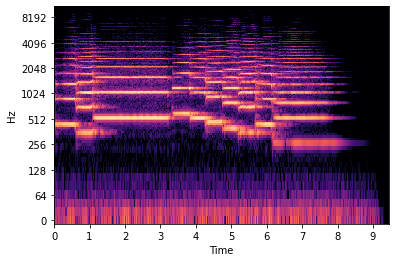

In [3]:
# get spectrogram
frame_size = 1048
hop_size = 512
STFT = librosa.stft(data, n_fft = frame_size, hop_length = hop_size)
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
img = librosa.display.specshow(STFT_db,
                                       y_axis='log',
                                       x_axis='time', 
                                       )

<h1 style = "font-size:3rem;color:orange">Band Energy Ratio</h1>

BER can be used to compare energy in different frequency bands (e.g. speech / speech discrimination or music genre classification)

\begin{equation}
    BER_t = \frac{\sum_{n=1}^{F-1}m_t(n)^2}{\sum_{n=F}^{N}m_t(n)^2},
\end{equation}
with split frequency $F$ (usually 2000 Hz).

In [4]:
def get_split_frequency_bin(STFT, split_frequency_in_Hz, sample_rate):
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / STFT.shape[0]  
    split_frequency_bin = np.floor(split_frequency_in_Hz / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [5]:
split_frequency_bin = get_split_frequency_bin(STFT, 2000, sr)
STFT.shape[1]

407

In [6]:
def get_band_energy_ratio(STFT, split_frequency_in_Hz, sample_rate):
    split_frequency_in_Hz = get_split_frequency_bin(STFT, split_frequency_in_Hz, sample_rate)
    
    # power spectrogram
    power_spec = np.abs(STFT) ** 2
    power_spec = power_spec.T
    
    BER = []
    
    for frequencies_in_frame in power_spec:
        sum_power_low_bins = np.sum(frequencies_in_frame[:split_frequency_bin])
        sum_power_high_bins = np.sum(frequencies_in_frame[split_frequency_bin:])
        ber_curr_frame = sum_power_low_bins / sum_power_high_bins
        BER.append(ber_curr_frame)
        
    return np.array(BER)

C:\Users\helme\AppData\Local\Temp\ipykernel_25520\3176819922.py:13: RuntimeWarning: invalid value encountered in float_scalars
  ber_curr_frame = sum_power_low_bins / sum_power_high_bins


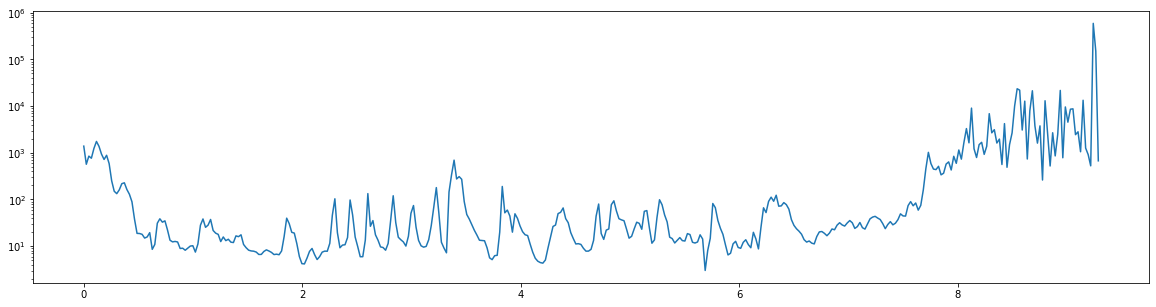

In [61]:
BER = get_band_energy_ratio(STFT, 2000, sr)

t = librosa.frames_to_time(range(0,len(BER)), hop_length=hop_size)

f = plt.figure(figsize=(20,5))
ax = plt.gca()
ax.set_yscale('log')
#ax.set_yscale('function', functions=(partial(np.power, 10.0), np.log10))
ax.plot(t,BER)


<h1 style = "font-size:3rem;color:orange">Spectral Centroid</h1>

Center of gravity of magnitude spectrum, can be used to measure 'brightness' of sound
\begin{equation}
    SC_t = \frac{\sum_{n=1}^{N}m_t(n) \cdot n }{\sum_{n=1}^{N}m_t(n)},
\end{equation}

with frequency bin $n$ and frame $t$.


In [144]:
def get_spectral_centroid(STFT,sr):
    spec = np.abs(STFT)
    spec_trans = spec.T

    SC = []
    
    num_bins = len(spec)
    num_frames = len(spec_trans)
    normalized_frequencies = range(0, num_bins)
    
    for frequencies_in_frame in spec_trans:
        normalized_spectrum = frequencies_in_frame / np.sum(frequencies_in_frame) 
        spectral_centroid = sum(normalized_frequencies * normalized_spectrum)
        SC.append(spectral_centroid * sr /(2* num_bins))
    return np.array(SC)
    

C:\Users\helme\AppData\Local\Temp\ipykernel_25520\476847733.py:12: RuntimeWarning: invalid value encountered in true_divide
  normalized_spectrum = frequencies_in_frame / np.sum(frequencies_in_frame)


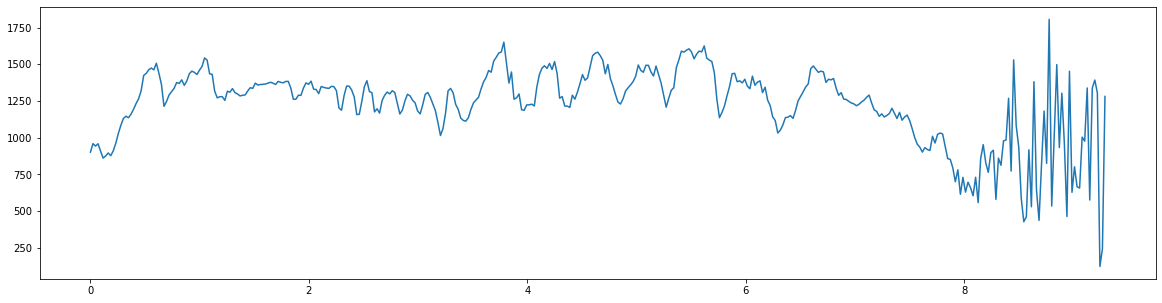

In [152]:
SC = get_spectral_centroid(STFT,sr)
frames = range(0,len(SC))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(20, 5))
plt.plot(t, SC);

<h1 style = "font-size:3rem;color:orange">Band Width</h1>

Weighted mean of the distances of frequency bands from spectral centroid
\begin{equation}
    BW_t = \frac{\sum_{n=1}^{N} |n - SC_t | \cdot m_t(n)}{\sum_{n=1}^{N}m_t(n)},
\end{equation}

with frequency bin $n$ and frame $t$.

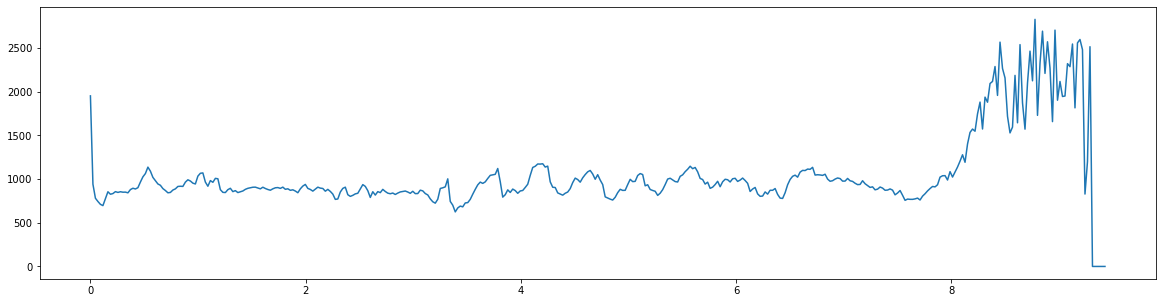

In [154]:
BW = librosa.feature.spectral_bandwidth(y = data, sr = sr, n_fft=frame_size, hop_length=hop_size)[0]
frames = range(0,len(BW))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(20, 5))
plt.plot(t, BW);